## Install dependencies

## Prepare data

15
7
8
Library functions included in the dataset: 32
train set samples: 10
Validation set samples: 5
test set samples: 10


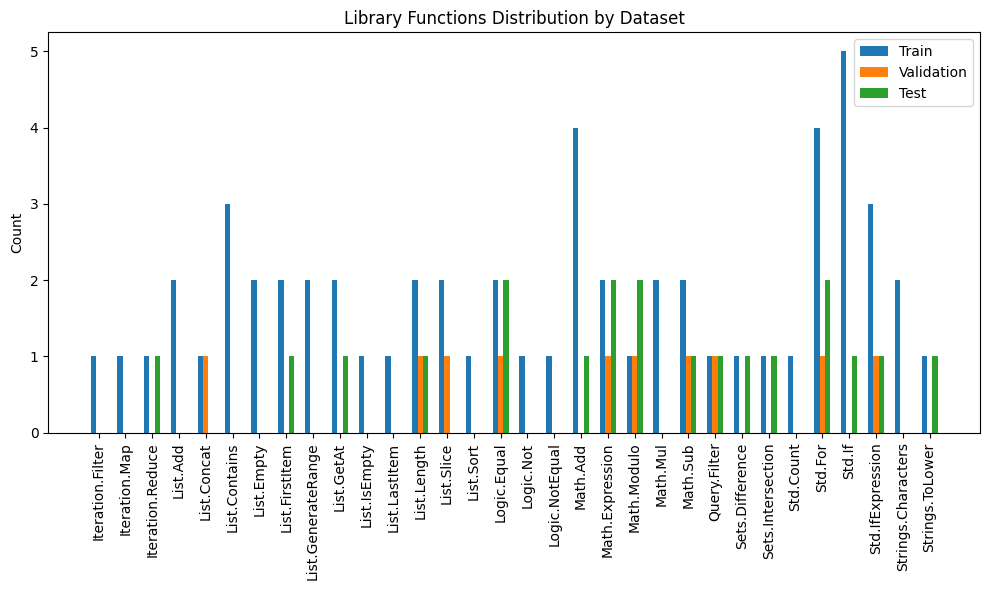

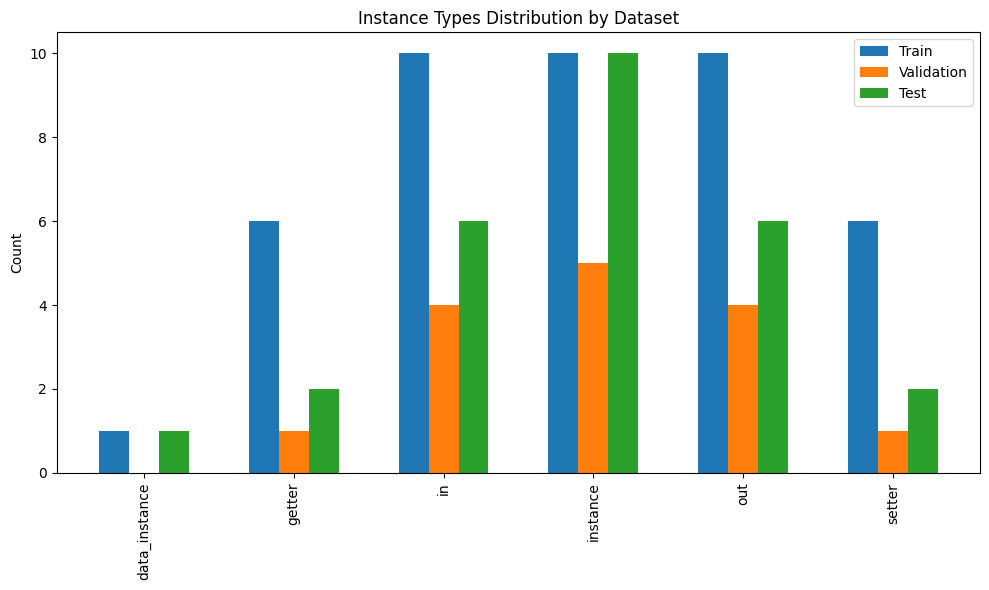

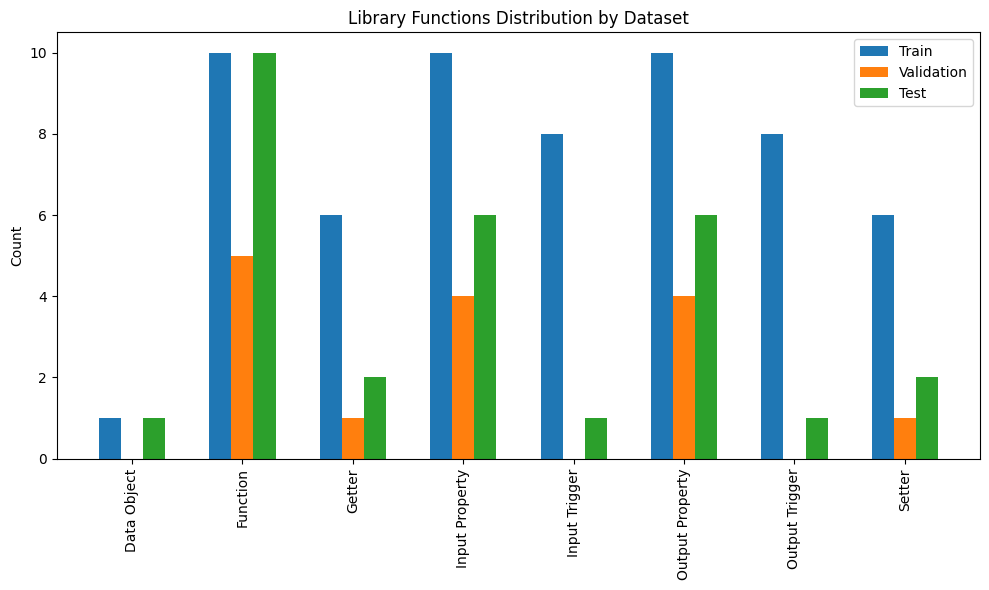

In [1]:
import json
import sys
sys.path.append('../')  # Add the path to the my_packages module
from my_packages.data_processing.split_dataset import split_on_shots, split
from my_packages.data_processing.get_labels_data import used_libraries_from_dataset
from my_packages.analysis.analyze_datasets import analyze_library_distribution, analyze_instance_distribution, analyze_visual_node_types_distribution

main_dataset_folder = '../data/mbpp_transformed_code_examples/sanitized-MBPP-midio.json'

# main dataset
with open(main_dataset_folder, 'r') as file:
    dataset = json.load(file)
    
num_shot = 10 # Few-shot examples
eval_size_percentage = 0.5
train_data, val_data, test_data = split_on_shots(num_shot, eval_size_percentage, dataset, seed = 64, write_to_file=True)

def extract_prompts_and_responses(data):
    prompts = [f"{item['prompts'][0]}\n " for item in data]
    # Responses from the library_functions list
    responses = []
    for sample in data:
        file_path = f"../data/mbpp_transformed_code_examples/only_files/task_id_{sample['task_id']}.midio"
        try:
            with open(file_path, 'r') as file:
                solution_code = file.read().strip()
                responses.append(solution_code)
        except FileNotFoundError:
            responses.append("File not found")
        except Exception as e:
            responses.append(f"Error: {e}")
    
    return prompts, responses

def used_libraries_to_string(data):
    name_doc_string = ""
    for func in data:
        name_doc_string += f"Name: {func['function_name']}\nDocumentation: {func['doc']}\n\n"
    return name_doc_string
    
# Extract training, validation, and test data
train_prompts, train_responses = extract_prompts_and_responses(train_data)  # Use as examples for few-shot learning
val_prompts, val_responses = extract_prompts_and_responses(val_data)  # Validation set
test_prompts, test_responses = extract_prompts_and_responses(test_data)  # Test set

# Extract all unique nodes (library_functions) across datasets
used_libraries_json = used_libraries_from_dataset(train_data)

explained_used_libraries = used_libraries_to_string(used_libraries_json)

print(f"train set samples: {len(train_prompts)}")
print(f"Validation set samples: {len(val_prompts)}")
print(f"test set samples: {len(test_prompts)}")

#Bar chart of distribuation
analyze_library_distribution(train_data, val_data, test_data)
analyze_instance_distribution(train_data, val_data, test_data)
analyze_visual_node_types_distribution(train_data, val_data, test_data)

## Create Prompt

In [2]:
# Function to create few-shot prompt
def create_few_shot_prompt(train_prompts, train_responses, input_prompt):
    Context = "You are going to solve some programming tasks for node-based programming language. Use minimal amount of library functions to solve the tasks.\n" 
    node_list = f"Only use the following library functions:\n {explained_used_libraries}\n\n"
    formatted_prompt = Context + node_list
    for i, (prompt, response) in enumerate(zip(train_prompts, train_responses)):
        formatted_prompt += f"Example {i+1}:\nPrompt: {prompt}\nResponse: {response}\n\n"
    formatted_prompt += f"Task:\n{input_prompt}\nResponse:"
    return formatted_prompt


## Test some Models, with different seeds, temperatures, top_ps

In [3]:
import requests
import json
# from my_packages.utils.dataset import find_max_tokens
from my_packages.evaluation.compiler import is_code_compilable

ollama_api_url = "http://localhost:11434/"
def load_model(model):
    response = requests.post(f"{ollama_api_url}/api/pull", json={"model": model, "stream": False})
    try:
        if response.status_code == 200:
            print("Model pulled successfully.")
            # print("Response data:", data)
        else:
            print("Error pulling model:", response.text)
    except json.JSONDecodeError as e:
        # The response is likely not valid JSON or contains extra data lines
        print("Probably returning a stream of data.")
        print("JSONDecodeError:", e)
        print("Raw response text:\n", response.text)
    return None

def ollama_generate(model, prompt, seed, max_new_tokens=50, temperature=0.7, top_p=0.9, stream=False):

    api_url = "http://localhost:11434/api/generate"
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": stream,
        "options": {
            "seed": seed,
            "temperature": temperature,
            "top_p": top_p,
            "max_tokens": max_new_tokens
        }
    }
    response = requests.post(api_url, json=payload, stream=stream)
    print("*****REPSONSE:")
    if response.status_code == 200:
        generated_text = ""
        #Iter json in case of streaming
        if stream:
            for line in response.iter_lines(decode_unicode=True):
                # print("line:", line)
                if line:
                    chunk = json.loads(line)
                    if "done" in chunk and chunk["done"]:
                        break
                    if "response" in chunk:
                        generated_text += chunk["response"]
        else:
            data = response.json()
            generated_text = data["response"]

        return generated_text
    else:
        print("Ollama API error:", response.text)
        return ""

# Function to generate and evaluate responses using Ollama
def evaluate(model, prompts, responses, seed, max_new_tokens=50, temperature=0.7, top_p=0.9):
    correct = 0
    total = len(prompts)
    for index, (prompt, true_response) in enumerate(zip(prompts, responses)):
        # full_prompt = create_few_shot_prompt(train_prompts, train_responses, prompt)
        generated = ollama_generate(
            model,
            "Hva er hovedstaden i Norge?",
            seed,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p
        )

        print(f"\n\nSample: {index}")
        print(f"Prompt: {prompt}")
        print(f"Generated response:\n {generated}")
        print(f"True response:\n {true_response}")

        if is_code_compilable(generated):
            print("Correct response: Code compiled successfully.")
            correct += 1
        else:
            print("Invalid response: Compilation failed.")

    return correct / total

# List of models to test
models_to_test = [
   {"name": "llama3"},
    # {"name": "mistralai/Mistral-Small-Instruct-2409", "cache_dir": "/projects/ec12/ec-sindrre/cache"},
    # {"name": "meta-llama/Llama-3.3-70B-Instruct", "cache_dir": "/projects/ec12/ec-sindrre/cache"},
    # {"name": "meta-llama/CodeLlama-70b-Instruct-hf", "cache_dir": "/projects/ec12/ec-sindrre/cache"},
    # {"name": "meta-llama/Llama-3.2-90B-Vision-Instruct", "cache_dir": "/projects/ec12/ec-sindrre/cache"}
]
# test
# load_model("llama3")
# print(ollama_generate(3,"print('Hello, World!')", "llama3", max_new_tokens=50, temperature=0.7, top_p=0.9, stream=True))
accuracy = evaluate("llama3", val_prompts, val_responses, 3, max_new_tokens=50, temperature=0.7, top_p=0.9)

# results = {}
# seeds = [3, 75, 346]

# for model_info in models_to_test:
#     print(f"Testing model: {model_info['name']}...")
#     text_gen_pipeline = create_ollama_pipeline()

#     # Suppose we skip the max_tokens from dataset analysis here
#     max_tokens = 50
#     print("max_tokens in dataset with current pipeline:", max_tokens)

#     for seed in seeds:
#         print(f"\nTesting with Seed: {seed}")
#         # We won't actually seed Ollama responses, but we keep logic for consistency
#         temperatures = [0.5, 0.7, 0.9]
#         top_ps = [0.2, 0.5, 1.0]
#         best_accuracy = 0
#         best_params = {"temperature": 0.7, "top_p": 0.9}

#         for temp in temperatures:
#             for top_p in top_ps:
#                 accuracy = evaluate_with_pipeline(
#                     text_gen_pipeline,
#                     val_prompts,
#                     val_responses,
#                     max_tokens,
#                     temperature=temp,
#                     top_p=top_p
#                 )
#                 print(f"Tested with temp={temp} and top_p={top_p}. Gave accuracy={accuracy}")
#                 if accuracy > best_accuracy:
#                     best_accuracy = accuracy
#                     best_params = {"temperature": temp, "top_p": top_p}

#         print(f"Best Hyperparameters for {model_info['name']}: {best_params}, Validation Accuracy: {best_accuracy:.2f}")

#         test_accuracy = evaluate_with_pipeline(
#             text_gen_pipeline,
#             test_prompts,
#             test_responses,
#             temperature=best_params["temperature"],
#             top_p=best_params["top_p"]
#         )

#         print(f"Test Accuracy for {model_info['name']}: {test_accuracy:.2f}")

#         if model_info["name"] not in results:
#             results[model_info["name"]] = []
#         results[model_info["name"]].append({
#             "seed": seed,
#             "validation_accuracy": best_accuracy,
#             "test_accuracy": test_accuracy
#         })

# print("\nFinal Results:")
# for model_name, metrics in results.items():
#     print(f"{model_name}:")
#     for run in metrics:
#         print(f"  Seed {run['seed']}: Validation Accuracy: {run['validation_accuracy']:.2f}, Test Accuracy: {run['test_accuracy']:.2f}")

*****REPSONSE:


Sample: 0
Prompt: Create a flow to rotate a given list by specified number of items to the right direction.
 
Generated response:
 Hovedstaden i Norge er Oslo!
True response:
 @midio_version("0.1.0")
@version("0.1.0")
import("std", Std_k98ojb)
import("http", Http_q7o96c)

module() main { 
    func(doc: "Rotates a given list by specified number of items to the right direction.") rotate_right {
        in(x: -186, y: -89.5, name: "list") property(List) list_48148f
        in(x: -193, y: -3.5, name: "n") property(Number) n_68068c

        out(x: 735.1, y: -112.54999999999995, name: "output") property(Any) output_823209

        instance(x: 348, y: -206) slice_710389 root.Std_k98ojb.List.Slice {}
        instance(x: 349.1, y: -0.5499999999999545) slice_479814 root.Std_k98ojb.List.Slice {}
        instance(x: 530.1, y: -109.54999999999995) concat_107778 root.Std_k98ojb.List.Concat {}
        instance(x: -36, y: -184) length_f7a32f root.Std_k98ojb.List.Length {}
        inst